In [1]:
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from trainer import train_model
from pathlib import Path
import numpy as np
import argparse
import os
from PIL import Image
import torchvision.models as models
import torchvision.transforms.functional as TF

In [16]:
import pandas as pd

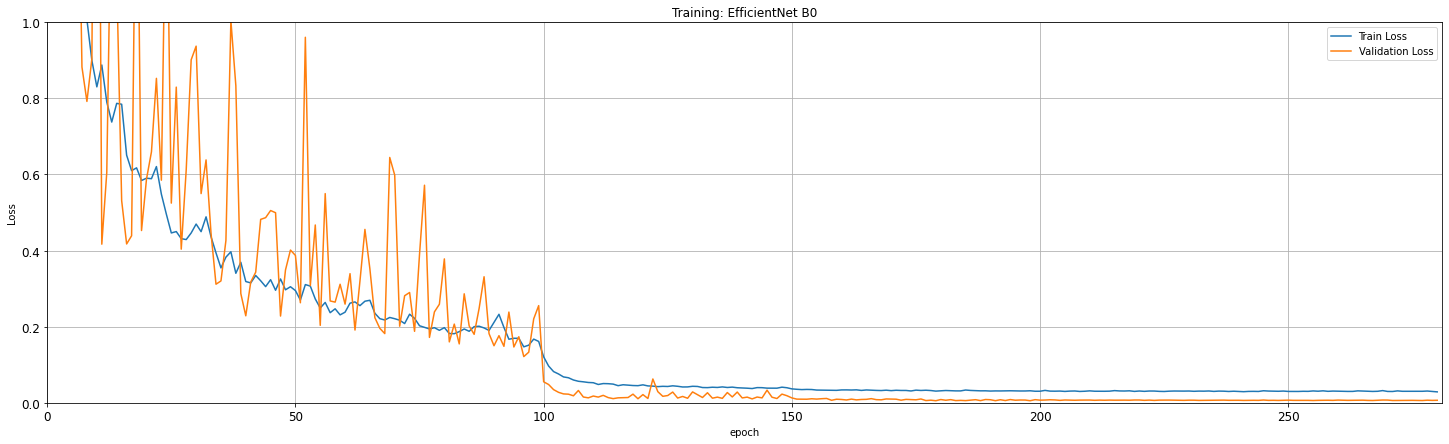

In [86]:
import matplotlib.pyplot as plt
adam_df = pd.read_csv("./results_adam/training_info.csv")
ax = adam_df[['train_loss', 'val_loss']].plot(title='Training: EfficientNet B0', figsize=(25, 7), fontsize=12, grid=True)
ax.set_xlabel("epoch")
ax.set_ylabel("Loss")
ax.set_ylim([0, 1])
ax.set_xlim([0, len(adam_df)])
plt.legend(["Train Loss", "Validation Loss"], loc=0)

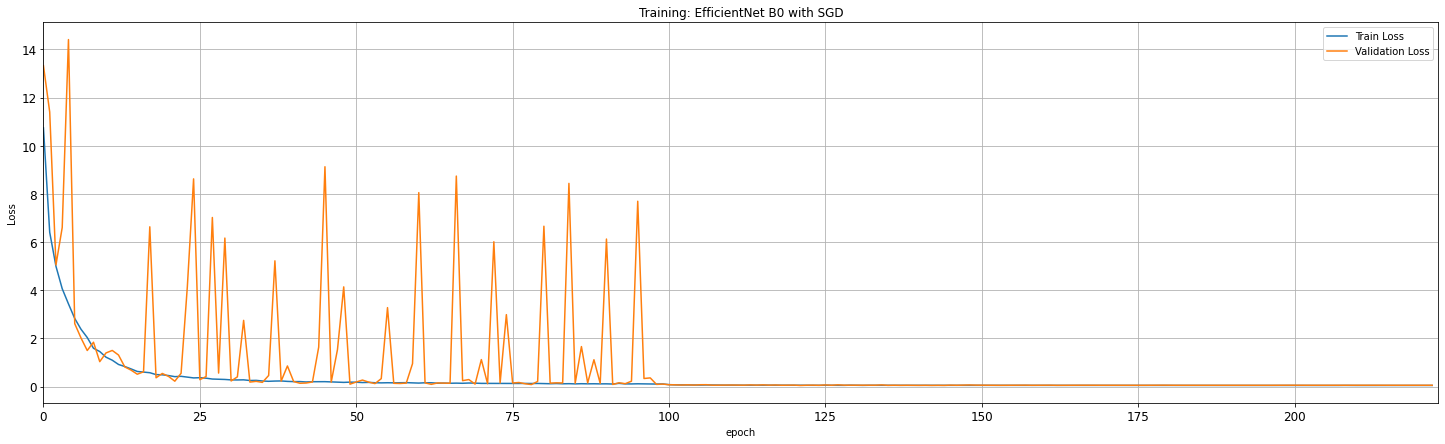

In [19]:
sgd_df = pd.read_csv("./results_sgd/training_info.csv")
ax = sgd_df[['train_loss', 'val_loss']].plot(title='Training: EfficientNet B0 with SGD', figsize=(25, 7), fontsize=12, grid=True)
ax.set_xlabel("epoch")
ax.set_ylabel("Loss")
# ax.set_ylim([0, 1])
ax.set_xlim([0, len(sgd_df)])
plt.legend(["Train Loss", "Validation Loss"], loc=0)

In [22]:
import time
def get_training_time(df):
    total_time = df.train_time.sum() + df.val_time.sum()
    ty_res = time.gmtime(total_time)
    return time.strftime("%H:%M:%S",ty_res)
print("Total Training Time SGD:", get_training_time(sgd_df))
print("Total Training Time Adam:", get_training_time(adam_df))

Total Training Time SGD: 13:46:03
Total Training Time Adam: 17:23:46


In [13]:
train_labels = open("./data/train.txt", "r").readlines()
test_labels = open("./data/test.txt", "r").readlines()
train_labels = [float(l.replace('\n', '')) for l in train_labels]
test_labels = [float(l.replace('\n', '')) for l in test_labels]

In [ ]:
for x in range(0, len(train_labels)):
    plt.figure(x)
    plt.plot([i for i in range(len(train_labels))], train_labels)
    plt.scatter(x=x, y=train_labels[x], color='r')
    plt.xlabel("frames")
    plt.ylabel("speed")
    plt.savefig(f"./regular_frames/plot/{x:05}")

Text(0, 0.5, 'speed')

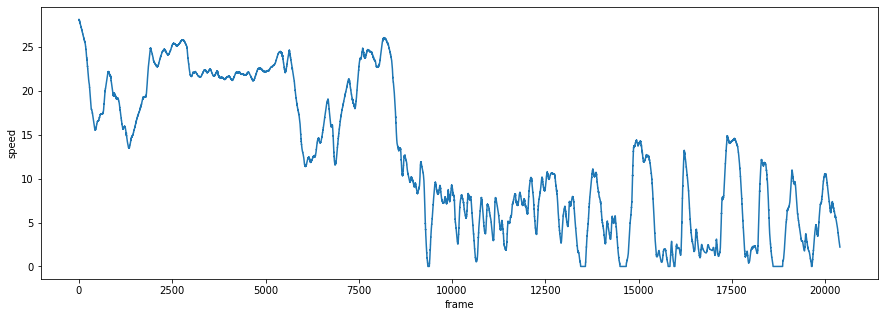

In [68]:
t = train_labels
plt.figure(figsize=(15, 5))
plt.plot([i for i in range(len(t))], t)
plt.xlabel("frame")
plt.ylabel("speed")

In [60]:
help(ax)

Help on AxesSubplot in module matplotlib.axes._subplots object:

class AxesSubplot(SubplotBase, matplotlib.axes._axes.Axes)
 |  AxesSubplot(fig, *args, **kwargs)
 |  
 |  Method resolution order:
 |      AxesSubplot
 |      SubplotBase
 |      matplotlib.axes._axes.Axes
 |      matplotlib.axes._base._AxesBase
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods inherited from SubplotBase:
 |  
 |  __init__(self, fig, *args, **kwargs)
 |      Parameters
 |      ----------
 |      fig : `matplotlib.figure.Figure`
 |      
 |      *args : tuple (*nrows*, *ncols*, *index*) or int
 |          The array of subplots in the figure has dimensions ``(nrows,
 |          ncols)``, and *index* is the index of the subplot being created.
 |          *index* starts at 1 in the upper left corner and increases to the
 |          right.
 |      
 |          If *nrows*, *ncols*, and *index* are all single digit numbers, then
 |          *args* can be passed as a single 3-digit number 

In [11]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
frame_path = "./regular_frames/train/"
of_path = "./dataset/train"
Hori = None
for i in range(0, 200):
    img1 = cv2.imread(os.path.join(frame_path, f"{i:05}.jpg"))
    img2 = cv2.imread(os.path.join(of_path, f"{i:05}.jpg"))
    # concatenate image Horizontally
    Hori = np.concatenate((img1, img2), axis=1)
    cv2.imwrite(f"./data/optical_flow/{i:05}.jpg", Hori)

In [63]:
import torch
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import torchvision.transforms.functional as TF

model = EfficientNet.from_pretrained(f'efficientnet-b0', in_channels=3, num_classes=1)
model.load_state_dict(torch.load("./results_adam/models/efficientnet-b0_final.pth", map_location=torch.device('cpu')))
model.eval()

class OFDataset(Dataset):
    """Dataset for optical flow images"""
    def __init__(self, of_dir, label_f, transform=None):
        self.transform = transform
        self.len = len(list(Path(of_dir).glob('*.jpg')))
        self.of_dir = of_dir
        self.label_file = open(label_f).readlines()[1:]

    def __len__(self): 
        return self.len

    def __getitem__(self, idx):
        image = Image.open(Path(self.of_dir)/f'{idx:05}.jpg')
        of_tensor = TF.to_tensor(image)if not self.transform else self.transform(TF.to_tensor(image))
        label = float(self.label_file[idx].split()[0])
        return [of_tensor, torch.tensor((label, ))]

test_dataset = OFDataset(os.path.join("./dataset", "test"), os.path.join("./data", "test.txt"))
testloader = DataLoader(test_dataset, batch_size=5, shuffle=False)

plot_path = "./regular_frames/plot_train"
frames = 0
font = cv2.FONT_HERSHEY_SIMPLEX
for i, (samples, labels) in enumerate(testloader):
    predictions = model(samples)
    print(predictions, labels)
    for i, (f, l, pred) in enumerate(zip(samples, labels, predictions)):
        img1 = f.squeeze().detach().cpu().numpy()
        cv2.putText(img1, f'Ground Truth : {l.item()}', (50, 50), font, 1, (0, 255, 255), 2, cv2.LINE_4)
        cv2.putText(img1, f'Prediction : {pred.item()}', (50, 100), font, 1, (0, 255, 255), 2, cv2.LINE_4)
        img2 = cv2.imread(os.path.join(plot_path, f"{frames:05}.png"))
        # concatenate image Horizontally
        Hori = np.concatenate((img1, img2), axis=1)
        cv2.imwrite(f"./data/test/{i:05}.jpg", Hori)
        frames += 1
    frames += labels.numel()
    break

Loaded pretrained weights for efficientnet-b0
tensor([[6.2285],
        [6.1981],
        [7.6325],
        [7.7775],
        [7.3694]], grad_fn=<AddmmBackward>) tensor([[6.1695],
        [7.5937],
        [7.7161],
        [7.3432],
        [8.9928]])


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 3 and the array at index 1 has size 288

Text(0, 0.5, 'Loss')

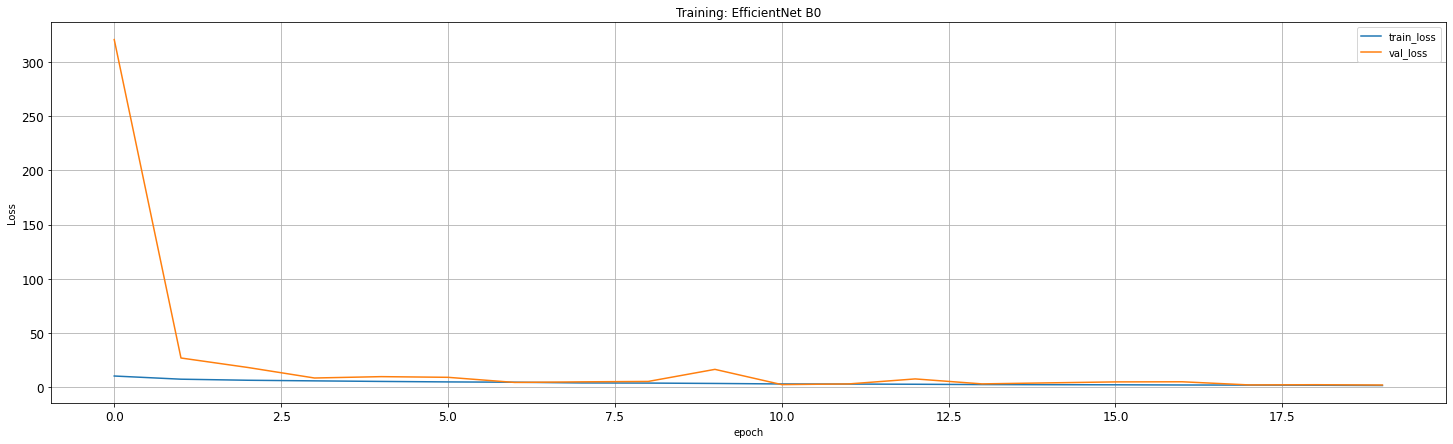

In [82]:
import matplotlib.pyplot as plt
enet_double = pd.read_csv("./enet_double/training_info.csv")
ax = enet_double[['train_loss', 'val_loss']].plot(title='Training: EfficientNet B0', figsize=(25, 7), fontsize=12, grid=True)
# adam_df = pd.read_csv("./results_adam/training_info.csv")
# adam_df[['train_loss', 'val_loss']].plot(title='Training: EfficientNet B0', figsize=(25, 7), fontsize=12, grid=True, ax=ax)
ax.set_xlabel("epoch")
ax.set_ylabel("Loss")
# ax.set_ylim([0, 2])
# ax.set_xlim([0, len(enet_double)])
# plt.legend(["Train Loss", "Validation Loss"], loc=0)

,epoch,train_loss,val_loss,train_time,val_time
0,0.0,10.439604,320.488299,178.882799,82.870245
1,1.0,7.502157,27.037639,172.948290,81.430418
2,2.0,6.527247,18.319009,172.563502,80.515318
3,3.0,5.967026,8.601037,171.992952,80.297771
4,4.0,5.441657,9.858277,171.788742,81.938941
5,5.0,4.998136,9.237420,172.970019,82.609092
6,6.0,4.713603,4.513125,172.422007,81.093135
7,7.0,4.060038,5.065663,172.386082,79.710108
8,8.0,3.924071,5.434500,171.781192,79.262748
9,9.0,3.585304,16.561104,172.748044,82.350839
